# To do
- [ ] Verificar a correlação entre as variáveis
- [ ] Verificar outliers
- [ ] Analizar disperção do preço por marca/ tamanho/ categoria

### Hipóteses
- Converter as colunas de condição para dados numéricos com os respectivos pesos importa na acurácia do modelo?


# Limpeza geral

In [ ]:
import re
import sys
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
from io import StringIO
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#####################################################

drive.mount('/content/drive', force_remount=True)
df = pd.read_csv('/content/drive/MyDrive/roupas_de_brechó/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/roupas_de_brechó/test.csv')

Mounted at /content/drive


## clean_df(df, train=False)

In [ ]:
def clean_df(df, train=True):
  original_stdout = sys.stdout
  sys.stdout = StringIO()

  import warnings

  # Ignorando todos os warnings
  warnings.filterwarnings("ignore")

  # base de dados das labels
  # y = df['VENDIDO']
  # base de dados das entradas
  if train == True:
    X = df[['marca', 'nomeDaPeca', 'precoComDesconto','precoSemDesconto', 'Descricao','Tamanho','Condicao', 'Cores', 'VENDIDO']]
  else:
    X = df[['marca', 'nomeDaPeca', 'precoComDesconto','precoSemDesconto', 'Descricao','Tamanho','Condicao', 'Cores']]
  #  União da base Test e Train para transformações em comum
  # X = pd.concat([X,df_test[['marca', 'nomeDaPeca', 'precoComDesconto','precoSemDesconto', 'Descricao','Tamanho','Condicao', 'Cores']]])

  X['Condicao'] = X['Condicao'].str.replace('Novo com etiqueta', 'nova com etiqueta' , case=False)
  X['Condicao'] = X['Condicao'].str.lower()

  ####################### MARCA ###########################

  marca = X['marca'].str.lower()
  mapeamento_marcas = ['sem marca', 'sem etiqueta', 'sem etiquera', 'semmarca', 'sem marca`', 'sem etqueta', 'sem marco', 'nan']
  X.marca = X.marca.astype(str)
  X.marca = X['marca'].apply(lambda x: x.strip())
  X["esta_na_lista"] = X['marca'].map(lambda x: x in mapeamento_marcas)
  df_filtrado = X['esta_na_lista']
  df_filtrado = df_filtrado.reset_index(drop=True)
  X = X.reset_index(drop=True)

  def preenche_marca(nome_completo):
    nome = nome_completo.split()
    for palavra in nome:
      if palavra in marca:
        return palavra
      else:
        return 'sem etiqueta'

  X.loc[df_filtrado, "marca"] = X["nomeDaPeca"].apply(preenche_marca)

  mapeamento_marcas_faltantes = {
      'juliana jabour': '	juliana jabour',
      'guaraná brasil': 'guaraná brasil',
      'thelure': 'thelure',
      'marcathelure.blusa': '	thelure',
      'atmosphere': '	atmosphere',
      'zara': 'zara',
      'animale': '	animale',
      'gap': ['	gap', 'tgap'],
      'tommy hilfiger': 'tommy hilfiger',
      'paradise': 'paradise',
      'puma': 'puma',
      'michael kors': 'michael kors',
      'evoke': 'evoke',
      'danny teich': 'danny teich',
      'trifil': 'trifil',
      'paul & joe branco': 'paul & joe branco',
      'john john': 'john john',
      'forever 21': 'forever 21',
      'ralph lauren': 'ralph lauren',
      'diesel': 'diesel',
      'aurea prates': 'aurea prates',
      'gucci': 'gucci',
      'liquido': 'liquido',
      'shoestock': 'shoestock',
      'colcci': 'colcci',
      'antix': 'antix',
      'iriá': 'iriá',
      'andré lima': 'andré lima',
      'roxy': 'roxy',
      'paul & joe': 'paul & joe',
      'billabong': 'billabong',
      'tommy hilfiger': 'tommy hilfiger',
      'linho fino': 'linho fino',
      'linho fino.': 'linho fino',
      'linho fino,': 'linho fino',
      'yessica.': 'yessica',
      'olook,': 'olook'
  }

  def substituir_marcas_vazias(row):
      if pd.notna(row['marca']) and 'sem etiqueta' in str(row['marca']).lower():
          for palavra, marca in mapeamento_marcas_faltantes.items():
              # Verifica se 'nomeDaPeca' não é nulo antes de aplicar lower()
              if pd.notna(row['nomeDaPeca']) and palavra in str(row['nomeDaPeca']).lower():
                  return marca
              # Verifica se 'Descricao' não é nulo antes de aplicar lower()
              if pd.notna(row['Descricao']) and palavra in str(row['Descricao']).lower():
                  return marca
      return row['marca']

  # Aplicando a função de substituição à coluna 'marca' do DataFrame
  X['marca'] = X.apply(substituir_marcas_vazias, axis=1)

  X['marca'] = X['marca'].str.replace(r'\s', '', regex=True)

  ####################### CORES ##############################

  cores = df['Cores'].str.lower()
  cores = cores.replace("\n", "",  regex=True)
  cores = cores.replace(r'\W', ' ', regex=True)
  cores = cores.str.strip()
  cores.dropna(inplace = True)
  cores = cores.reset_index(drop = True)
  for i, cor in enumerate(cores):
    if len(cor.split()) > 1:
      cores[i] = cores[i].replace(cor, "NA")

  mapeamento_cores = {
      'colorido': ['multicolorido', 'xadrez', 'listrado', 'mesclado', 'estampado', 'poá', 'colorido',
                  'florido', 'florida', 'listrada', 'floral', 'pb', 'barroco', 'animal print', 'colorida',
                  'multicor', 'étnica', 'étnico', 'animalprint', 'onça', 'zebra', 'etnic', 'madras', 'furtacor', 'quadriculada',
                  'python', 'cores', 'oncinha', 'jacquard', 'pied de poule', 'tweed', 'bicolor', 'mix', 'furta cor', 'flores',
                  'listras', 'flora', 'tie dye', 'escritas', 'degradê', 'geométrica', 'geométrico', 'listrinhas', 'p&b', 'risca de giz',
                  'kimono', 'strass', 'arcoiris', 'arco iris', 'cobra', 'print','bolinhas', 'estonada', 'carangueijos', 'melancia', 'listradinha',
                  'snake', 'listradica', 'monograma', 'tricolor', 'corações', 'manchas', 'flower', 'white&blue', 'camuflagem'],

      'azul': ['jeans', 'denim', 'azul', 'navy', 'marinho', 'bic','turquesa', 'blue', 'petróleo', 'azuis', 'petroleo'],
      'vinho': ['bordô', 'vinho', 'marsala','burgundy', 'borgonha', 'bordo'],
      'marrom': ['tijolo', 'canela', 'terra', 'marrom', 'marom', 'marrons', 'speed turtle', 'castanho', ' terrosos'],
      'rosa': ['pink', 'rosê', 'coral', 'salmão', 'magenta', 'rosa', 'pêssego', 'rosé', 'fúcsia', 'rose', 'rosie', 'cereja',' fucsia', 'rosè'],
      'cinza': ['chumbo', 'cinza', 'grafite'],
      'roxo': ['lilás', 'roxo', 'roxa', 'berinjela'],
      'bege': ['fendi', 'nude', 'caramelo', 'bege', 'cáqui', 'cru', 'bambu', 'palha', 'caqui', 'camelo', 'areia', 'beje'],
      'verde': ['verde','limão', 'grass', 'green', 'musgo', 'oliva'],
      'preto': ['preto', 'preta', 'preto', 'black', 'pretinho'],
      'vermelho': ['vermelho', 'vermelha', 'red', 'blood'],
      'laranja': ['laranja', 'orange'],
      'branco': ['branco', 'branca', 'off-white', 'off white', 'creme', 'offwhite', 'off', 'gelo', 'pérola'],
      'dourado': ['dourado', 'dourada', 'ouro', 'champagne', 'gold', 'champanhe'],
      'prata': ['prata', 'prateado', 'prateada'],
      'amarelo': ['amarelo', 'amarela', 'mostarda', 'amarelinho', 'açafrão'],
      'bronze': ['bronze', 'cobre', 'bronza'],
      'transparente': ['transparente'],
      'neon': ['neon']
  }

  def preencher_cores(row):
      for coluna in ['nomeDaPeca', 'Descricao']:
          descricao = row[coluna]
          if pd.notna(descricao):
              descricao = descricao.lower()
              descricao = re.sub(r'\W', ' ', descricao)
              for grupo, cores_grupo in mapeamento_cores.items():
                  for cor in cores_grupo:
                      if cor in descricao:
                          return grupo
              if 'estampa' in descricao or 'estampada' in descricao:
                  return 'colorido'
      return np.nan

  X['Cores'] = ''
  X['Cores'] = X.apply(lambda row: preencher_cores(row), axis=1)

  X = X.apply(lambda col: col.astype(str).str.lower())
  X['Cores'] = X.apply(lambda row: preencher_cores(row), axis=1)

  ###############################################

  X.replace('\n','',regex=True, inplace=True)
  X[['marca', 'nomeDaPeca', 'Descricao', 'Tamanho', 'Condicao', 'Cores']] = X[['marca', 'nomeDaPeca', 'Descricao', 'Tamanho', 'Condicao', 'Cores']].apply(lambda x: x.str.lower())
  X = X.reset_index(drop=True)
  X['nomeDaPeca'].str.split().str[0]

  mapeamento_peca = {
      'blusa': ['blusa', 'top', 'regata', 'blusinha', 'cropped', 'camiseta', 'túnica', 'bata', 't-shirt', 'camisete', '.camiseta',
                'camisetinha', 'ciganinha', 'regatinha', 'batinha', 'tshirt', 'cigana', 'blusinhas', 'camseita', 'raglan', 'topcropped',
                'businha', 'croppped', 'busa', 'blusas', 'camisetão', 'camista', 'ragata', 'regat', 'cropeed', 't', 'regatona', 'rgata',
                'bluusa', 'blusinnha', 't--shirt', 'bluza', 'maxiblusa', 'cachecouer', 'frente', 'look', 'tomara', 'tomara-que-', 'tomara-que-caia',
                'alcinhas', 'alcinha', 'basic', 'basica', 'básica', ' power'],
      'saia': ['saia', 'peplum', 'minissaia', 'kilt', 'camisão', 'missaia', 'sainha', 'lápis', 'minisaia', 'tapa'],
      'sapato': ['sapatilha', 'anabela', 'sandalia', 'sandália', 'alpargatas', 'alpargata', 'bota', 'sapato', 'tênis', 'chinelo', 'scarpin',
                'rasteirinha', 'chuteira', 'peep', 'salto', 'galocha', 'pantalona', 'mocassim', 'rasteira', 'scarpim', 'espadrille', 'oxford',
                'slipper', 'mule', 'ankle', 'sapatênis', 'sadália', 'sandalia', 'tamanco', 'toe', 'rasterinha', 'espadrilhe', 'gladiadora',
                'peeptoe', 'sneaker', 'sapatinho', 'botinha', 'tenis', 'flatform', 'plataforma', 'espadrile', 'crocs', 'espadrilha', 'sapatinha',
                'anabella', 'sapatillha', 'papete', 'spatilha', 'sandálias', 'rateira', 'tenhis', 'rasteita', 'botina', 'espadilhe', 'chinelinho',
                'espardrille', 'sandálida', 'sapatos', 'scarpn', 'sacarpin', 'tênois', 'sapatilhas', 'scarin', 'clog', 'resteirinha', 'sandáia',
                'sapatoto', 'coturno', 'slide', 'slip', 'dock', 'derby', 'eda´s', 'melissa', 'havaianas', 'schutz', 'mulle'],
      'short': ['shorts', 'short', 'bermuda', 'shortinho', 'shorts-saia', 'hotpants', 'hot', 'hotpant', 'shortinhos', 'shrts', 'bermudinha',
                'short-saia', 'barmuda', 'shorta', 'shots', 'shors', 'bemuda', 'bermula', 'shorst', 'short-'],
      'vestido': ['vestido', 'tunica', 'vestidinho', 'vetido', 'vestdo', 'vestidos', 'kaftan', 'vesido', 'vestid', 'vestio', 'vestidoverde',
                  'vestodo', 'veestido', 'vestiso', 'salopete', 'kaftans', 'vestidio', 'vesitdo', 'vestidotira', 'dress', 'vestidocolorido',
                  'tubinho', 'vest', 'chamise', 'longo', 'blusê'],
      'acessório': ['óculos', 'oculos', 'oculo', 'colar', 'cinto', 'gravata', 'brinco', 'chemise', 'cachecol', 'lenço', 'pulseira', 'babador',
                    'luva', 'meia', 'arquinho', 'choker', 'anel', 'bandana', 'capa', 'capinha', 'bracelete', 'tiara', 'faixa', 'boina', 'meias',
                    'faixinha', 'relógio',  'pulseiras', 'lenços', 'chaveiro', 'turbante', 'luvas', 'écharpe', 'laços', 'relogio', 'echarpe',
                    'chokers', 'óculo', 'óculso', 'cola', 'gratava', 'correntinha', 'gavata', 'broche', 'ray', 'polaina','cinto/faixa', 'grampo',
                    'munhequeira','presilha',  'semijoias', 'chocker', 'brincos', 'armação', 'lençinho', 'lencço','luvinhas',  'gargantilha',
                    'anelbolinhas', 'laço', 'rélogio', 'òculos',  'pingente', 'cintos', 'acessório', 'munhequeria', 'anéis', 'protetor', 'porta',
                    'bijuterias', 'gola', 'ear', 'turca'],
      'outros': ['manta', 'mantinha', 'patins', 'guitarra', 'perfume', 'ipad', 'case', 'celular', 'modular', 'jogo', 'agenda', 'fantasia', 'livro',
                'panela'],
      'bolsa': ['bolsa', 'bolsinha', 'clutch', 'carteira', 'clutche', 'mochilinha', 'pochete', 'mala', 'minibag', 'necessaire', 'birken', 'bosinha',
                'necessarie', 'mochila', 'maxibolsa', 'sacola', 'cluch', 'handbag', 'clutches', 'maleta', 'pasta', 'mini-bolsa', 'malinha', 'carteria',
                'bolsa-saco', 'mochilia', 'chutch', 'cluthe', 'saco', 'ecobag', 'clucth','frasqueira', 'cartão', 'bag', 'tintamar'],
      'chapelaria': ['boné', 'touca', 'chapéu','viseira', 'chápeu', 'chapéus', 'gorro', 'toca', 'bone', 'touquinha'],
      'camisa': ['camisa', 'polo', 'camisas', 'camiza', 'camisetas', 'pólo'],
      'casaco': ['casaco', 'moletom', 'suéter', 'tricot', 'malha', 'jaqueta', 'casaqueto', 'cardigan', 'sobretudo', 'tricô', 'cardigã',
                'blusão', 'trench', 'sueter', 'cardigam', 'bomber', 'parka', 'casaquinho', 'cadigan', 'moletinho', 'sweater', 'trico', 'estola',
                'casacão', 'pullover', 'moleton', 'jaquetinha', 'agasalho', 'coat', 'cardingan', 'moleto', 'corta', 'pulover', 'casaqueta', 'hoodie',
                'casquinho', 'casaco/colete', 'corta-vento', 'trenchcoat', 'casaqueo', 'súeter', 'jaqueto', 'parca', 'cargidã', 'casqueto', 'jaquela',
                'cacharrel', 'pull', 'cashime'],
      'poncho': ['poncho', 'xale', 'chale', 'ponho'],
      'roupa social': ['paletó',  'paleto', 'terno', 'palitó','balzer', 'blazer', 'tailleur', 'blazerb', 'brazer', 'spencer'],
      'roupa íntima': ['sutiã', 'calcinha', 'corpete', 'corset', 'sutiâ', 'corselet', 'cinta', 'meia-calça', 'suitã', 'lingerie', 'calcinhas',
                      'bustier', 'soutien', 'babydoll', 'espartilho', 'corsele', 'cueca', 'sutião', 'corselete', 'lingeire', 'doll', 'loungerie',
                      'intimo', 'samba'],
      'body': ['body', 'collant', 'body-vestido'],
      'peça única': ['macaquinho', 'macacão', 'jardineira', 'macacao', 'jardineirinha', 'jumpsuit', 'macacaquinho', 'macacquinho', 'macacâo',
                    'macaquinhos', 'maquinho', 'jardinheira', 'macaquinhoa', ],
      'colete': ['colete', 'bolero', 'kimono', 'quimono', 'boleto', 'bolerinho', 'colote', 'coletinho','coletetropical', 'pelerine'],
      'calça': ['calça', 'legging', 'pantacourt', 'pantalona', 'saruel', 'flare', 'calca', 'leggins', 'skinny', 'capri', 'sweatpants', 'pantacout', 'calçasocial',
                'carça', 'caça', 'leeging', 'jegging', 'sarouel', 'leging', 'claça', 'cigarrete', 'legginf', 'corsário', 'pantalone', 'mijão', 'jeans', 'denim',
                'denin', 'pants'],
      'homewear': ['pijama', 'camisola', 'pantufa', 'robe','pantufas', 'roupão', 'hobby', 'pijamas'],
      'moda praia': ['biquíni', 'biquini', 'maiô', 'saída', 'bíquíni', 'canga', 'maio', 'sunga', 'bíquini', 'saida', 'biquiíni', 'biquiní', 'biquínis'],
      'conjunto': ['conjunto']

  }

  X["Descricao"] = X["Descricao"].fillna("")
  def mapear_pecas(nome_completo):
    nome = nome_completo.split()
    for palavra in nome:
      for chave, valores in mapeamento_peca.items():
        if palavra in valores:
          return chave
    return np.nan

  X['pecas'] = X['nomeDaPeca'].apply(mapear_pecas)
  mask = X["pecas"].isna()
  X.loc[mask, "pecas"] = X['Descricao'].apply(mapear_pecas)
  print(X["pecas"])

  ##################################################

  X["Descricao"] = X["Descricao"].fillna("")
  def mapear_pecas(nome_completo):
    nome = nome_completo.split()
    for palavra in nome:
      for chave, valores in mapeamento_peca.items():
        if palavra in valores:
          return chave
    return np.nan

  X['pecas'] = X['nomeDaPeca'].apply(mapear_pecas)
  mask = X["pecas"].isna()
  X.loc[mask, "pecas"] = X['Descricao'].apply(mapear_pecas)
  print(X["pecas"])

 ###################################################
  mapeamento_tamanhos = {
      'colar': 'U',
      'tamanho p': '36',
      'mochilinha': 'U',
      '37': '37',
      'tam m': '38',
      'pulseira': 'U',
      '34': '34',
      'bolsa': 'U',
      'bijuterias': 'U',
      'relogio': 'U',
      'tam p': '36',
      'óculos': 'U'
  }

  def substituir_tamanhos(row):
      if pd.isna(row['Tamanho']):
          for palavra, tamanho in mapeamento_tamanhos.items():
              if palavra in row['nomeDaPeca'].lower() or palavra in row['Descricao'].lower():
                  return tamanho
      return row['Tamanho']

  X['Tamanho'] = X.apply(substituir_tamanhos, axis=1)

  X.loc[X['Tamanho'].isna(), 'Tamanho'] = 'Não informado'

  ###############################################

  # retirando os \n
  X.replace('\n','',regex=True, inplace=True)
  # Remoção de caracteres do alfabeto
  X['precoComDesconto'] = X['precoComDesconto'].str.extract(r'(\d+[.,\d]*)')
  X['precoSemDesconto'] = X['precoSemDesconto'].str.extract(r'(\d+[.,\d]*)')

  # Troca dos caracteres de virgula para ponto nas colunas preço
  X['precoComDesconto'] = X['precoComDesconto'].str.replace(',', '.')
  X['precoSemDesconto'] = X['precoSemDesconto'].str.replace(',', '.')

  def format_preco(test):
      try:
          test = test.split('.')
          test = test[0] + test[1] + '.' + test[2]
      except:
          test = 0
      return test

  # formatando preços com dois pontos (milhar e centavos)
  X.loc[X[X['precoComDesconto'].str.replace('\d+', '').str.count('.') == 2].index,'precoComDesconto'] = X.loc[X[X['precoComDesconto'].str.replace('\d+', '').str.count('.') == 2].index,'precoComDesconto'].apply(lambda x: format_preco(x) )
  X.loc[X[X['precoSemDesconto'].str.replace('\d+', '').str.count('.') == 2].index,'precoSemDesconto'] = X.loc[X[X['precoSemDesconto'].str.replace('\d+', '').str.count('.') == 2].index,'precoSemDesconto'].apply(lambda x: format_preco(x) )

  # transformando as colunas 'precoSemDesconto' e 'precoComDesconto' no tipo float
  X['precoSemDesconto'] = X['precoSemDesconto'].astype(float)
  X['precoComDesconto'] = X['precoComDesconto'].astype(float)

  # atribuindo para valores nulos na coluna 'precoSemDesconto' o valor 0
  X.loc[X[X['precoSemDesconto'].isnull()].index,'precoSemDesconto'] = X['precoComDesconto'].mean()

  # criando coluna nova chamada preco_final (precoSemDesconto - precoComDesconto)
  X['preco_final'] = X['precoSemDesconto'] - X['precoComDesconto']

  sys.stdout = original_stdout
  warnings.filterwarnings("default")
  return X


In [ ]:
cleaned_df = clean_df(df)
cleaned_test_df = clean_df(df_test, train=False)

In [ ]:
cleaned_df.Tamanho = cleaned_df.Tamanho.str.strip()
cleaned_test_df.Tamanho = cleaned_test_df.Tamanho.str.strip()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Gráficos

In [ ]:
!pip install plotly dash

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 57.2 MB/s eta 0:00:00


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/ansi2html-1.8.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/us

In [ ]:
cleaned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDrive2ImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarn

,marca,nomeDaPeca,precoComDesconto,precoSemDesconto,Descricao,Tamanho,Condicao,Cores,VENDIDO,esta_na_lista,pecas,preco_final
0,semetiqueta,blusa verde babados,64.00,160.0,blusa verde com modelagem básica. peça com bab...,m,gentilmente usada,verde,0,true,blusa,96.00
1,zara,saia lápis zara,57.00,219.0,marca: zara woman,38,gentilmente usada,NaN,1,false,saia,162.00
2,1a9,jeans skinny 1 a 9,69.00,279.0,"medidas: cintura 32cm, quadril 43cm, comprime...",38,gentilmente usada,azul,0,false,calça,210.00
3,coach,sapatilha monograma,250.00,875.0,sapatilha caramelo. possui monograma em toda a...,39,usado,colorido,1,false,sapato,625.00
4,primeiroitemteen,shorts feminino teen corações,20.97,69.9,"shorts feminino, com estampa de corações, do p...",m,gentilmente usada,colorido,0,false,short,48.93
...,...,...,...,...,...,...,...,...,...,...,...,...
78326,mandi,camisa preta mandi,15.00,69.9,"camisa feminina, preta, da mandi. tecido plano...",m,gentilmente usada,preto,0,false,camisa,54.90
78327,mo,saia branca bordada,33.75,135.0,"saia branca com bordados em linha prata, azul ...",p,gentilmente usada,branco,1,false,saia,101.25
78328,luigibertolli,vestido floral preto e vermelho luigi bertolli,27.48,89.9,"vestido preto com flores vermelhas, da luigi b...",gg,gentilmente usada,colorido,1,false,vestido,62.42
78329,zara,blazer tweed bege,70.00,280.0,"blazer em tweed, nas cores bege e dourado. pos...",p,usado,colorido,1,false,roupa social,210.00


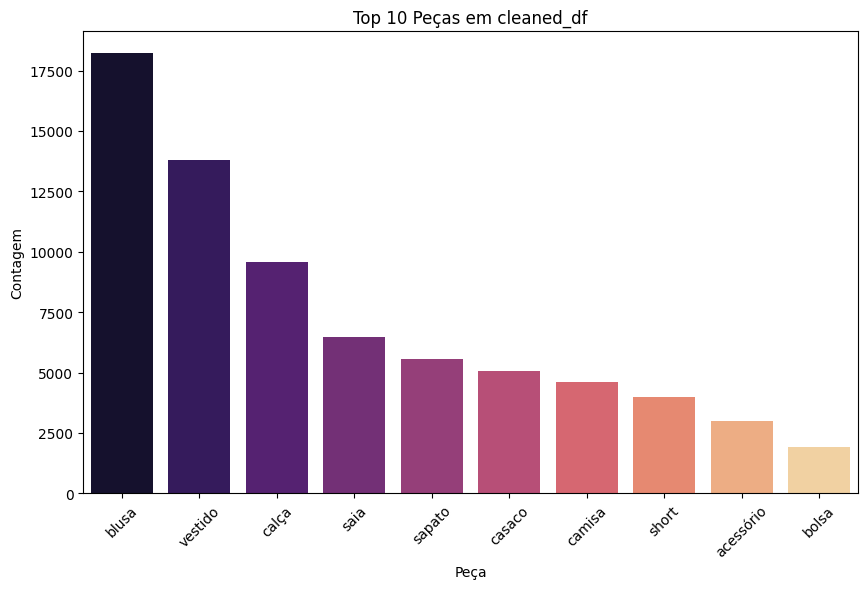

In [ ]:
# Contar a frequência de cada peça
top_pieces = cleaned_df['pecas'].value_counts().head(10)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=top_pieces.index, y=top_pieces.values, palette="magma")

# Adicionar título e rótulos aos eixos
plt.title('Top 10 Peças em cleaned_df')
plt.xlabel('Peça')
plt.ylabel('Contagem')

# Rotacionar rótulos do eixo x para melhor legibilidade
plt.xticks(rotation=45)

# Exibir o gráfico
plt.show()

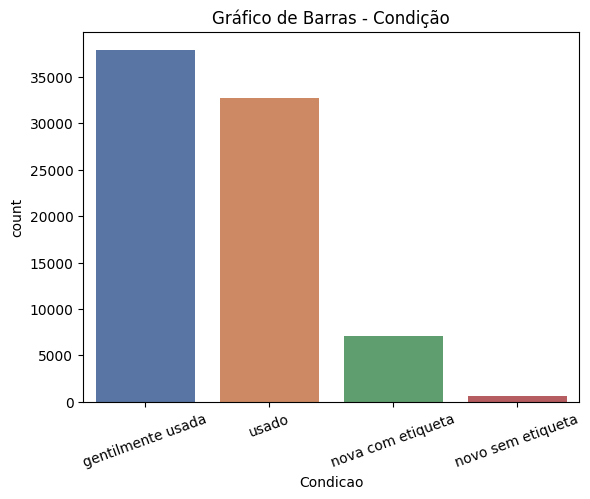

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Substitua 'Condicao' pelo nome real da coluna que você deseja usar para o gráfico de barras
sns.countplot(x='Condicao', data=cleaned_df, palette="deep")
plt.title('Gráfico de Barras - Condição')
plt.xticks(rotation=20)
plt.show()

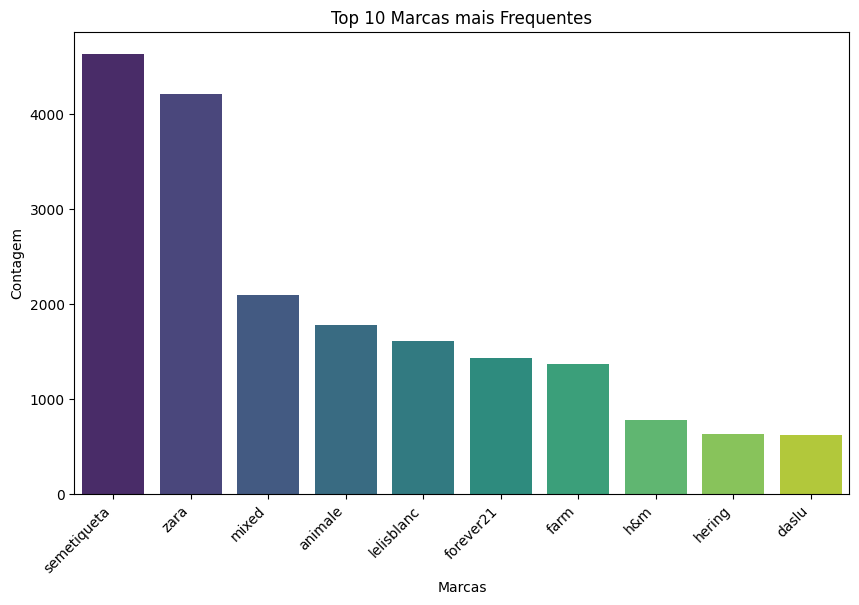

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assumindo que a coluna que contém as marcas é chamada 'Marca'. Substitua conforme necessário.
top_10_marcas = cleaned_df['marca'].value_counts().nlargest(10)

# Cria um gráfico de barras usando Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_marcas.index, y=top_10_marcas.values, palette='viridis')
plt.title('Top 10 Marcas mais Frequentes')
plt.xlabel('Marcas')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos no eixo x para facilitar a leitura
plt.show()


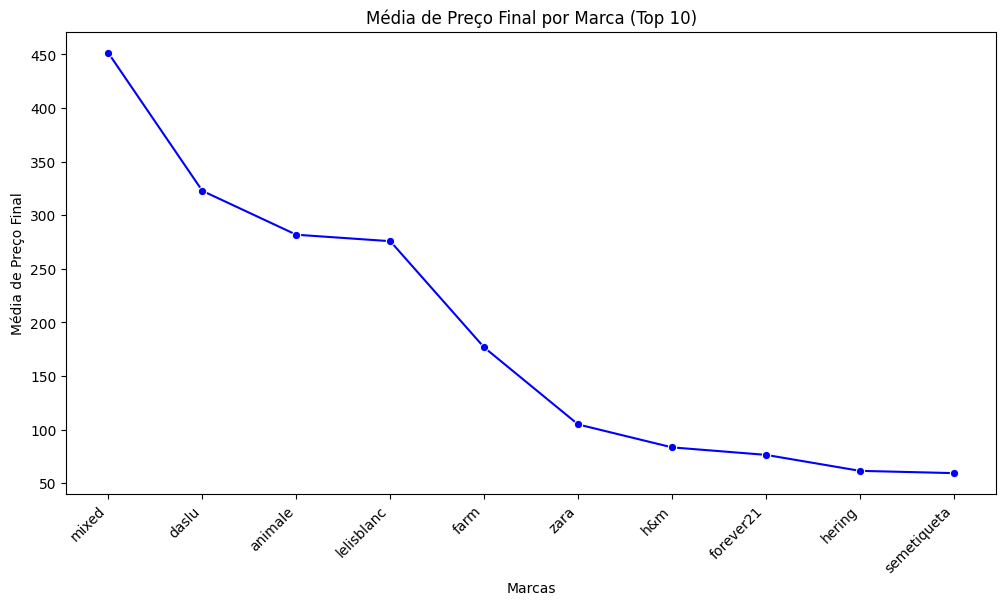

In [ ]:
# Assumindo que as colunas são chamadas 'Marca' e 'preco_final'. Substitua conforme necessário.
top_10_marcas = cleaned_df['marca'].value_counts().nlargest(10).index

# Filtra o dataframe para incluir apenas as 10 principais marcas
filtered_df = cleaned_df[cleaned_df['marca'].isin(top_10_marcas)]

# Calcula as médias de 'preco_final' para cada marca
media_precos_por_marca = filtered_df.groupby('marca')['preco_final'].mean().sort_values(ascending=False)

# Cria um gráfico de linha usando Seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x=media_precos_por_marca.index, y=media_precos_por_marca.values, marker='o', color='b')
plt.title('Média de Preço Final por Marca (Top 10)')
plt.xlabel('Marcas')
plt.ylabel('Média de Preço Final')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos no eixo x para facilitar a leitura
plt.show()

#ML

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.2-py2.py3-none-any.whl size=265363806 sha256=e59d9033d85a3fe32bd64e1d1ae33bf219a35516b1f5a0c3cc5d87df9bb706e8
  Stored in directory: /root/.cache/pip/wheels/e9/ea/ab/889709967692e30c57c46137edd2cae6b2768bb65ec7cb8aa5
Successfully built h2o


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/dist-packages/google/colab/_pip.py:85: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.10/dist-packages/h2o-3.44.0.2.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [ ]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

train_frame = h2o.H2OFrame(cleaned_df)

X = ['marca', 'precoComDesconto', 'precoSemDesconto', 'Tamanho', 'Condicao', 'Cores', 'pecas', 'preco_final']
y = 'VENDIDO'

train_frame['VENDIDO'] = train_frame['VENDIDO'].asfactor()

aml = H2OAutoML(max_runtime_secs=600, seed=42)
aml.train(x=X, y=y, training_frame=train_frame)

lb = aml.leaderboard
print(lb)

best_model = aml.leader


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20.1" 2023-08-24; OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphi7ube4_
  JVM stdout: /tmp/tmphi7ube4_/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphi7ube4_/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ...

/usr/local/lib/python3.10/dist-packages/h2o/backend/server.py:139: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/tmphi7ube4_/h2o_unknownUser_started_from_python.out' mode='w' encoding='utf-8'>
  hs._launch_server(port=port, baseport=baseport, nthreads=int(nthreads), ea=enable_assertions,
/usr/local/lib/python3.10/dist-packages/h2o/backend/server.py:139: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/tmphi7ube4_/h2o_unknownUser_started_from_python.err' mode='w' encoding='utf-8'>
  hs._launch_server(port=port, baseport=baseport, nthreads=int(nthreads), ea=enable_assertions,


 successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,10 days
H2O_cluster_name:,H2O_from_python_unknownUser_xlor9o
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
StackedEnsemble_AllModels_1_AutoML_1_20231118_220432     0.722667   0.591898  0.796503                0.418553  0.451455  0.203812
StackedEnsemble_BestOfFamily_2_AutoML_1_20231118_220432  0.72126    0.592961  0.7952                  0.422457  0.451935  0.204245
StackedEnsemble_BestOfFamily_1_AutoML_1_20231118_220432  0.720753   0.593419  0.794948                0.417527  0.452146  0.204436
XGBoost_1_AutoML_1_20231118_220432                       0.712972   0.600349  0.788676                0.433746  0.455318  0.207314
XGBoost_2_AutoML_1_20231118_220432                       0.709056   0.601562  0.785607                0.428721  0.455988  0.207925
GBM_1_AutoML_1_20231118_

In [ ]:
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20231118_220432,0.722667,0.591898,0.796503,0.418553,0.451455,0.203812
StackedEnsemble_BestOfFamily_2_AutoML_1_20231118_220432,0.72126,0.592961,0.7952,0.422457,0.451935,0.204245
StackedEnsemble_BestOfFamily_1_AutoML_1_20231118_220432,0.720753,0.593419,0.794948,0.417527,0.452146,0.204436
XGBoost_1_AutoML_1_20231118_220432,0.712972,0.600349,0.788676,0.433746,0.455318,0.207314
XGBoost_2_AutoML_1_20231118_220432,0.709056,0.601562,0.785607,0.428721,0.455988,0.207925
GBM_1_AutoML_1_20231118_220432,0.707127,0.603059,0.779904,0.421438,0.456347,0.208252
GBM_4_AutoML_1_20231118_220432,0.703923,0.60513,0.778248,0.42255,0.457404,0.209218
GBM_3_AutoML_1_20231118_220432,0.703526,0.604848,0.778782,0.428161,0.457364,0.209182
GBM_2_AutoML_1_20231118_220432,0.70103,0.606673,0.775658,0.435539,0.458128,0.209881
GBM_5_AutoML_1_20231118_220432,0.688791,0.616311,0.767216,0.437418,0.462582,0.213982


In [ ]:
best_model.accuracy()[0][1]

0.7632269789983845

In [ ]:
best_model.confusion_matrix()

,0,1,Error,Rate
0,1948.0,1996.0,0.5061,(1996.0/3944.0)
1,506.0,5454.0,0.0849,(506.0/5960.0)
Total,2454.0,7450.0,0.2526,(2502.0/9904.0)


In [ ]:
perf = best_model.model_performance()
perf.plot(type = "roc")

In [ ]:
best_model.predict(train_frame)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
1,0.576087,0.423913
1,0.287165,0.712835
1,0.53095,0.46905
1,0.546282,0.453718
1,0.368717,0.631283
1,0.554798,0.445202
0,0.679237,0.320763
1,0.172539,0.827461
1,0.625831,0.374169
1,0.308331,0.691669


In [ ]:
# Fazer previsões no conjunto de dados original
y_pred = best_model.predict(train_frame)

y_pred = y_pred.as_data_frame()['predict']

# Converter as previsões para strings
y_pred = y_pred.astype(str)

# Obter os rótulos reais
y_test = cleaned_df['VENDIDO'].astype(str)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo:", accuracy)



stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Acurácia do modelo: 0.7062082700335754


In [ ]:
test_frame = h2o.H2OFrame(cleaned_test_df)
y_pred = best_model.predict(test_frame)
previsoes = y_pred.as_data_frame()[['predict']]

previsoes.to_csv('previsoes.csv')
previsoes = pd.read_csv('/content/previsoes.csv')
previsoes.columns = ['index', 'VENDIDO']
previsoes.to_csv(path_or_buf = 'previsoes_final.csv', index=False)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'marca' has levels not trained on: ["16lost", "1989", "1989place", "1ºitem", "204", "23°graus", "23ºgraus", "284paracea", "2:haus", "2b", ...3046 not listed..., "zzstyle", "zínia", "àlagarçonne", "águamarinha", "águasclaras", "áreakb", "ármariodaana", "éppica", "índia", "índigojeans"]
  warnings.warn(w)
/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'Tamanho' has levels not trained on: ["4g", "g2"]
  warnings.warn(w)


In [ ]:
pd.read_csv('/content/previsoes_final.csv')

,index,VENDIDO
0,0,0
1,1,1
2,2,1
3,3,0
4,4,1
...,...,...
38577,38577,1
38578,38578,1
38579,38579,1
38580,38580,1


PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_1_AutoML_2_20231117_184612 on column 'Condicao'.
condicao           mean_response    stddev_response    std_error_mean_response
-----------------  ---------------  -----------------  -------------------------
gentilmente usada  0.511587         0.209133           0.000747231
nova com etiqueta  0.678544         0.179547           0.000641521
novo sem etiqueta  0.697193         0.20666            0.000738398
usado              0.703636         0.197861           0.000706959]

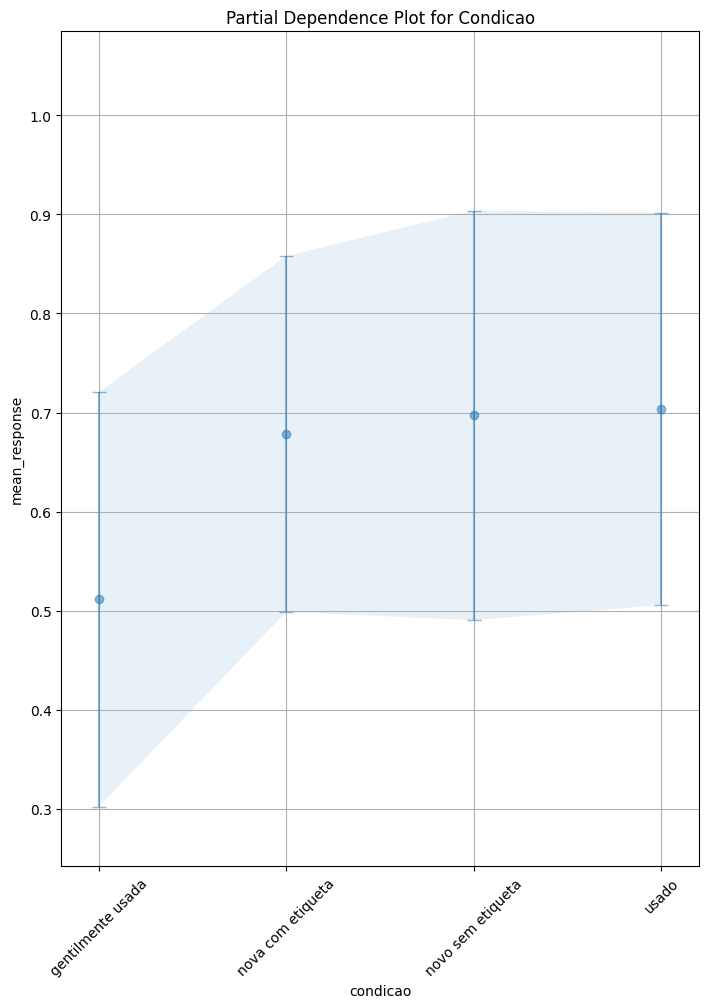

In [ ]:
best_model.partial_plot(train_frame, cols=['Condicao'])

PartialDependencePlot progress: |████████████████████████████████████████████████| (done) 100%


[PartialDependence: Partial Dependence Plot of model StackedEnsemble_AllModels_1_AutoML_2_20231117_184612 on column 'Cores'.
cores         mean_response    stddev_response    std_error_mean_response
------------  ---------------  -----------------  -------------------------
amarelo       0.542489         0.200492           0.000716357
azul          0.610526         0.186232           0.000665408
bege          0.603408         0.189988           0.000678829
branco        0.610353         0.186316           0.000665708
bronze        0.56433          0.196175           0.000700933
cinza         0.587444         0.205901           0.000735684
colorido      0.606012         0.188055           0.00067192
dourado       0.631333         0.173813           0.000621035
laranja       0.527074         0.199136           0.000711512
marrom        0.592999         0.188863           0.000674808
nan           0.677091         0.163342           0.00058362
neon          0.589748         0.200369      

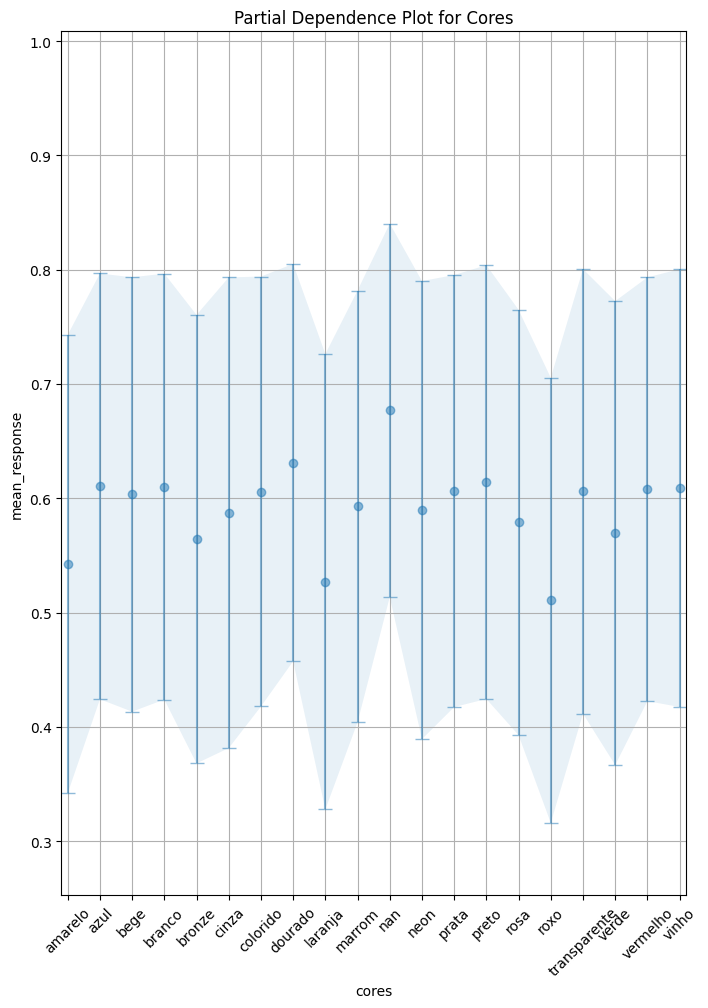

In [ ]:
best_model.partial_plot(train_frame, cols=['Cores'])

In [ ]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
metalearner = h2o.get_model(aml.leader.metalearner()['name'])

/usr/local/lib/python3.10/dist-packages/h2o/estimators/stackedensemble.py:945: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


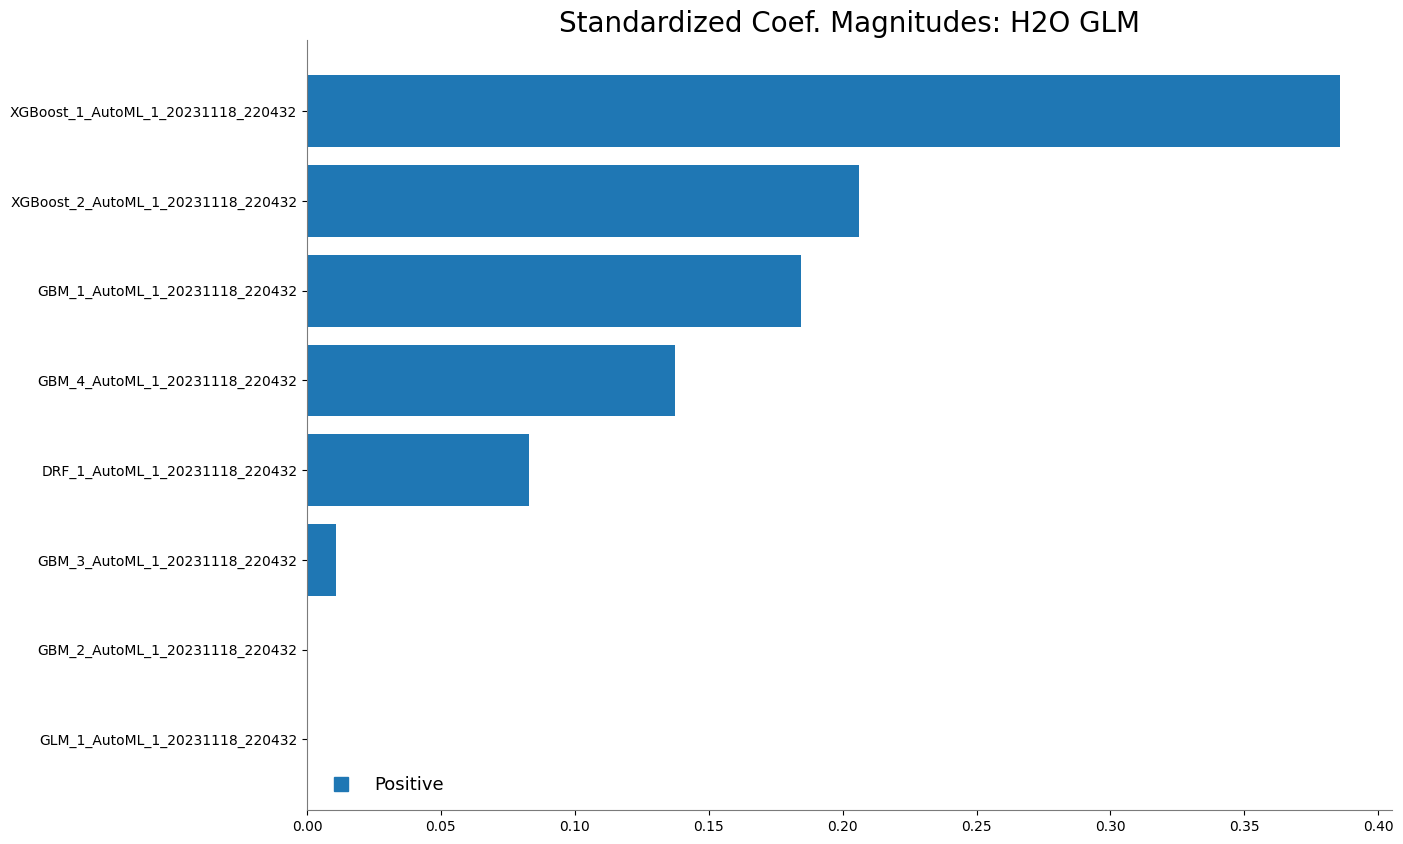

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()


In [ ]:
metalearner.std_coef_plot()

In [ ]:
cleaned_df.isna().sum()

marca                  0
nomeDaPeca             0
precoComDesconto       0
precoSemDesconto       0
Descricao              0
Tamanho                0
Condicao               0
Cores               1450
VENDIDO                0
esta_na_lista          0
pecas                 11
preco_final            0
dtype: int64

In [ ]:
h2o.save_model(best_model, path='/content/clothes_best_model_bin')

'/content/clothes_best_model_bin/StackedEnsemble_AllModels_1_AutoML_2_20231117_184612'

In [ ]:
# Encerre o cluster H2O
# h2o.cluster().shutdown()